In [1]:
from tdc.multi_pred import DTI
import numpy as np
from get_dataloaders import get_dataloaders
from SimpleDTA import SimpleDTA
import torch
from matplotlib import pyplot as plt 
from sklearn.metrics import r2_score
import time 

In [2]:
# 'BindingDB_Kd'
train_loader, test_loader, valid_loader = get_dataloaders(batch_size=400, num_workers=8, dataset='KIBA', split='cold_drug')
len(train_loader)

Found local copy...
Loading...
Done!


mean: 11.723854152210857
std: 0.8420492446261757
train dataset size: 80823
test dataset size: 24010
valid dataset size: 12824


203

In [3]:
# KIBA 
# train dataset size: 83673
# test dataset size: 22271
# valid dataset size: 11713

'''_y = []
for i,(_data) in enumerate(train_loader): 
    print(f'progress: {i}/{len(train_loader)}', end='\r')
    _y.append(_data.y.detach().numpy())

_y = np.concatenate(_y)

plt.figure()
plt.title('Train Data')
plt.hist(_y, bins=100)
plt.show()

_y = []
for i,(_data) in enumerate(test_loader): 
    print(f'progress: {i}/{len(test_loader)}', end='\r')
    _y.append(_data.y.detach().numpy())

_y = np.concatenate(_y)

plt.figure()
plt.title('Test data')
plt.hist(_y, bins=100)
plt.show()'''

"_y = []\nfor i,(_data) in enumerate(train_loader): \n    print(f'progress: {i}/{len(train_loader)}', end='\r')\n    _y.append(_data.y.detach().numpy())\n\n_y = np.concatenate(_y)\n\nplt.figure()\nplt.title('Train Data')\nplt.hist(_y, bins=100)\nplt.show()\n\n_y = []\nfor i,(_data) in enumerate(test_loader): \n    print(f'progress: {i}/{len(test_loader)}', end='\r')\n    _y.append(_data.y.detach().numpy())\n\n_y = np.concatenate(_y)\n\nplt.figure()\nplt.title('Test data')\nplt.hist(_y, bins=100)\nplt.show()"

In [4]:
model = SimpleDTA(embedding_dim     =   50, 
                  drug_kernel_size  =   [3,5,9], 
                  prot_kernel_size  =   [3,7,13], 
                  hidden_channels   =   32, 
                  latent_channels   =   124, 
                  mlp_out_channels  =   512, 
                  dropout           =   0.1, 
                  encoder           =   'cnn-lstm', 
                  embedding_type    =   'trainable').to('cuda')


print('drug enc:', sum(p.numel() for p in model.drug_encoder.parameters()))
print('prot enc:', sum(p.numel() for p in model.prot_encoder.parameters()))
print('mlp out:', sum(p.numel() for p in model.mlp_out.parameters()))

drug enc: 398302
prot enc: 398302
mlp out: 260609


In [5]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

In [6]:

for epoch in range(100): 
    loss_avg = 0 
    tic = time.time() 
    _y_train = []
    _yhat_train = []

    for data in train_loader: 
        optim.zero_grad()
        model.train()
        data.to('cuda')
        yhat = model(data.smiles_idx, data.aa_idx).squeeze(-1)
            
        loss = crit(yhat, data.y)
        loss.backward() 
        torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
        optim.step()

        loss_avg += loss.detach().cpu().numpy().item() / len(train_loader)
        _y_train.append( data.y.detach().cpu().numpy() )
        _yhat_train.append( yhat.detach().cpu().numpy() ) 

    with torch.no_grad(): 
        model.eval()
        test_loss = 0 
        _y_test = []
        _yhat_test = []
        for data in test_loader: 
            data.to('cuda')
            yhat = model(data.smiles_idx, data.aa_idx).squeeze(-1)
            test_loss += crit(yhat, data.y).detach().cpu().numpy().item() / len(test_loader)

            _y_test.append( data.y.detach().cpu().numpy() )
            _yhat_test.append( yhat.detach().cpu().numpy() ) 

    # calc metrics -- train 
    y_train = np.concatenate(_y_train)
    yhat_train = np.concatenate(_yhat_train)
    r2_train = r2_score(y_train, yhat_train)
    corr_train = np.corrcoef(y_train, yhat_train)[0,1]
    #              -- test
    y_test = np.concatenate(_y_test)
    yhat_test = np.concatenate(_yhat_test)
    r2_test = r2_score(y_test, yhat_test)
    corr_test = np.corrcoef(y_test, yhat_test)[0,1]
    # 

    print(f'(train, test) || epoch: {epoch} | loss: ({loss_avg:.4f}, {test_loss:.4f}) | r2: ({r2_train:.2f}, {r2_test:.2f}) | corr: ({corr_train:.2f},{corr_test:.2f}) | time/epoch: {time.time()-tic:.1f} s')
    tic = time.time()

(train, test) || epoch: 0 | loss: (64.4478, 0.9191) | r2: (-90.31, -0.41) | corr: (0.04,0.14) | time/epoch: 148.4 s
(train, test) || epoch: 1 | loss: (1.8081, 0.5576) | r2: (-1.55, 0.14) | corr: (0.16,0.41) | time/epoch: 147.2 s
(train, test) || epoch: 2 | loss: (1.7114, 0.7993) | r2: (-1.10, -0.20) | corr: (0.23,-0.06) | time/epoch: 147.1 s
(train, test) || epoch: 3 | loss: (1.6794, 0.6288) | r2: (-1.26, 0.05) | corr: (0.15,0.35) | time/epoch: 147.2 s
(train, test) || epoch: 4 | loss: (1.4800, 0.6883) | r2: (-0.91, -0.02) | corr: (0.14,0.35) | time/epoch: 147.3 s
(train, test) || epoch: 5 | loss: (1.3461, 0.5968) | r2: (-0.90, 0.09) | corr: (0.06,0.32) | time/epoch: 147.0 s
(train, test) || epoch: 6 | loss: (1.0971, 0.5731) | r2: (-0.53, 0.12) | corr: (0.18,0.37) | time/epoch: 147.3 s
(train, test) || epoch: 7 | loss: (1.0807, 0.5511) | r2: (-0.52, 0.15) | corr: (0.13,0.39) | time/epoch: 147.1 s
(train, test) || epoch: 8 | loss: (0.9259, 0.5587) | r2: (-0.30, 0.14) | corr: (0.25,0.39)

KeyboardInterrupt: 

In [10]:
'''
(train, test) || epoch: 0 | loss: (31.2822, 18.9522) | r2: (-15.28, -8.78) | corr: (0.25,0.36) | time/epoch: 37.6 s
(train, test) || epoch: 1 | loss: (7.9772, 2.0388) | r2: (-3.16, -0.05) | corr: (0.25,0.41) | time/epoch: 37.0 s
(train, test) || epoch: 2 | loss: (2.5916, 1.6797) | r2: (-0.35, 0.13) | corr: (0.35,0.46) | time/epoch: 36.2 s
(train, test) || epoch: 3 | loss: (2.2735, 1.5503) | r2: (-0.18, 0.20) | corr: (0.40,0.49) | time/epoch: 37.1 s
(train, test) || epoch: 4 | loss: (2.0295, 1.6185) | r2: (-0.05, 0.17) | corr: (0.45,0.50) | time/epoch: 36.6 s
(train, test) || epoch: 5 | loss: (1.8978, 1.6048) | r2: (0.01, 0.18) | corr: (0.48,0.52) | time/epoch: 37.1 s
(train, test) || epoch: 6 | loss: (1.7136, 1.4792) | r2: (0.11, 0.24) | corr: (0.52,0.54) | time/epoch: 36.1 s
(train, test) || epoch: 7 | loss: (1.6016, 1.3765) | r2: (0.17, 0.29) | corr: (0.55,0.56) | time/epoch: 37.8 s
(train, test) || epoch: 8 | loss: (1.4950, 1.5406) | r2: (0.22, 0.20) | corr: (0.57,0.54) | time/epoch: 37.7 s
(train, test) || epoch: 9 | loss: (1.4077, 1.2997) | r2: (0.27, 0.33) | corr: (0.60,0.60) | time/epoch: 37.8 s
(train, test) || epoch: 10 | loss: (1.3425, 1.4468) | r2: (0.30, 0.26) | corr: (0.61,0.58) | time/epoch: 37.9 s
(train, test) || epoch: 11 | loss: (1.2646, 1.4056) | r2: (0.34, 0.28) | corr: (0.63,0.59) | time/epoch: 37.0 s
(train, test) || epoch: 12 | loss: (1.1905, 1.3804) | r2: (0.38, 0.29) | corr: (0.66,0.59) | time/epoch: 36.7 s
(train, test) || epoch: 13 | loss: (1.1428, 1.4009) | r2: (0.41, 0.28) | corr: (0.67,0.62) | time/epoch: 36.5 s
(train, test) || epoch: 14 | loss: (1.0849, 1.5583) | r2: (0.44, 0.20) | corr: (0.69,0.59) | time/epoch: 36.5 s
(train, test) || epoch: 15 | loss: (1.0575, 1.4536) | r2: (0.45, 0.25) | corr: (0.69,0.61) | time/epoch: 37.0 s
(train, test) || epoch: 16 | loss: (1.0043, 1.6594) | r2: (0.48, 0.15) | corr: (0.71,0.58) | time/epoch: 37.9 s
(train, test) || epoch: 17 | loss: (0.9368, 1.6231) | r2: (0.51, 0.16) | corr: (0.73,0.59) | time/epoch: 37.5 s
(train, test) || epoch: 18 | loss: (0.9113, 1.5589) | r2: (0.53, 0.20) | corr: (0.74,0.59) | time/epoch: 38.5 s
(train, test) || epoch: 19 | loss: (0.8810, 1.6847) | r2: (0.54, 0.13) | corr: (0.75,0.59) | time/epoch: 38.2 s
(train, test) || epoch: 20 | loss: (0.8359, 1.5042) | r2: (0.57, 0.22) | corr: (0.76,0.58) | time/epoch: 38.0 s
(train, test) || epoch: 21 | loss: (0.8132, 1.4501) | r2: (0.58, 0.25) | corr: (0.77,0.61) | time/epoch: 37.7 s
(train, test) || epoch: 22 | loss: (0.7701, 1.4526) | r2: (0.60, 0.25) | corr: (0.78,0.61) | time/epoch: 37.2 s
'''

False
False
False
True


In [7]:
loss

tensor(0.6889, device='cuda:0', grad_fn=<MseLossBackward0>)

In [9]:
yhat.size()

torch.Size([400])

In [11]:
data.y.size()

torch.Size([400])

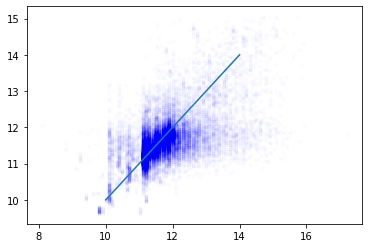

In [10]:

plt.figure()
plt.plot(y_test, yhat_test, 'b.', alpha=0.01)
plt.plot((10,14), (10,14))
plt.show()